# AIBECS beta-test

Welcome to the beta test of the AIBECS!
Well, we are not sure about the name yet, but as of now, AIBECS stands for the **Algebraic Implicit Biogeochemistry Elemental-Cycling System**.
AIBECS may be pronounced like the cool [ibex](https://en.wikipedia.org/wiki/Ibex) (if you have a french accent).
AIBECS is a new software written in [Julia](https://julialang.org) to easily create some marine biogeochmistry models in just a few commands.

*AIBECS is developed primarily by Benoît Pasquier (pasquieb@uci.edu) with the help of François Primeau (fprimeau@uci.edu) and J. Keith Moore (jkmoore@uci.edu).*

**Wait, I'm confused... What is AIBECS exactly?**

AIBECS is not just a single model.
It's a **system** that allows you to create a global steady-state biogeochmistry model with just a few simple commands.
Basically, you just need to tell AIBECS
- (i) which ocean circulation to use (from simple toy models of just a few boxes to more complicated global models of the circulation),
- (ii) what elements you want to model/track and how each tracer gets converted into other tracers, and
- (iii) chose some model parameters to start with.
Once the model is set up, you can run simulations.

**"Algebraic", "implicit", what do these mean? I thought I was doing some oceanography today...**

Well, AIBECS relies on many tools from linear algebra to run simulations and perform optimizations really fast.
AIBECS-generated models are described by a state function, denoted $\boldsymbol{F}$, which defines how the concnetrations of elements in the ocean evolve with time.
In mathematical terms, this translates to a system of nonlinear differential equations with the generic form 

$$\frac{\partial \boldsymbol{x}}{\partial t} = \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\boldsymbol{x}$ is the state of the model (i.e., the concentrations of the tracers), and $\boldsymbol{p}$ are model parameters.
Here, we are interested in the equilibrium of the system (AKA the steady-state).
That is when the time-derivative is $0$, so that

$$\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0,$$

and $\boldsymbol{x}$ does not change with time.
Instead of simulating the evolution of $\boldsymbol{x}$ with time and waiting for the system to reach equilibrium — like most biogeochemistry models do — AIBECS uses linear algebra techniques, like Newton's method in multiple dimensions, or Krylov spaces, to implicitly solve for the steady-state solution, hence the "algebraic" and "implicit" names.
This makes AIBECS much faster than the competition!
Note again that we are not set on the name of the software yet, so if you have a good idea, don't hesitate to share it with us!

## OK, enought words, show me some AIBECS action!

First things first, we must tell Julia that we want to use the package:

In [1]:
using TransportMatrixTools

┌ Info: Recompiling stale cache file /Users/lorencalle/.julia/compiled/v1.1/TransportMatrixTools/6EUXl.ji for TransportMatrixTools [3487739c-c12e-11e8-1d55-2958ce19ee2a]
└ @ Base loading.jl:1184
┌ Warning: Error requiring Unitful from Flatten:
│ ArgumentError: Package Flatten does not have Unitful in its dependencies:
│ - If you have Flatten checked out for development and have
│   added Unitful as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Flatten
│ Stacktrace:
│  [1] require(::Module, ::Symbol) at ./loading.jl:836
│  [2] top-level scope at /Users/lorencalle/.julia/packages/Flatten/AXBiq/src/Flatten.jl:21
│  [3] eval at ./boot.jl:328 [inlined]
│  [4] eval at /Users/lorencalle/.julia/packages/Flatten/AXBiq/src/Flatten.jl:1 [inlined]
│  [5] (::getfield(Flatten, Symbol("##3#6")))() at /Users/lorencalle/.julia/packages/Requires/9Jse8/src/require.jl:67
│  [6] err(::getfield(Flatten, 

If it's the first time you are running this line, the package will be precompiled. 
This may take a minute or two.
Just be patient :)
You might also see some warnings, just disregard those...
If you get an error though, this is the end of our adventure for now...
Please send me a copy of the output/error message, and I will try to troubleshoot it.
(Note the `Error requiring Unitful from Flatten` is actually a warning, not an error, so you should be fine if that's the only thing you see.)

### Set up a model

Let's start with a very simple model.
We will simulate the ideal mean age of water.
That is, the average amount of time since a water parcel had last contact with the surface.
Here the "surface" will be the top layer of the model grid.
So, we have one tracer, the age, which we will denote by `age` in Julia.
But before diving into the equations, let us chose the circulation. 

#### The circulation

We will use the circulation output from the Ocean Circulation Inverse Model (OCIM) version 1.1.
Basically, the OCIM provides scientists, like you and me, with a big sparse matrix that represents the global ocean circulation (advection and diffusion).
(For more details, see Tim DeVries's [website](https://tdevries.eri.ucsb.edu/models-and-data-products/) and references therein.)
With AIBECS, the OCIM circulation can be loaded really easily, by simply typing 

In [2]:
const wet3d, grd, T_OCIM = TransportMatrixTools.OCIM1.load() ;

loading OCIM1 with JLD2
This program has requested access to the data dependency MatricesForJAMES.
which is not currently installed. It can be installed automatically, and you will not see this message again.

References:
- DeVries, T. (2014), The oceanic anthropogenic CO2 sink: Storage, air‐sea fluxes, and transports over the industrial era, Global Biogeochem. Cycles, 28, 631–647, doi:10.1002/2013GB004739.
- DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, https://doi.org/10.1175/JPO-D-10-05011.1



Do you want to download the dataset from http://files.figshare.com/14330492/OCIM1_CTL.jld2 to "/Users/lorencalle/.julia/datadeps/MatricesForJAMES"?
[y/n]


stdin>  y


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0    116      0  0:00:01  0:00:01 --:--:--   116
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100  388M  100  388M    0     0  1904k      0  0:03:28  0:03:28 --:--:-- 3213k
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = "345dc8a49445d02091cfe06818bc4ee617bf33dee7f8d92f298c26ed74d84684"
└ @ DataDeps /Users/lorencalle/.julia/packages/DataDeps/LiEdA/src/verification.jl:44


(We use the `const` prefix to tell Julia these are constants — it makes Julia faster!)
Julia may ask you to download the OCIM matrix for you, in which case you should say yes (i.e., type `y`).
Once downloaded, TransportMatrixTools will remember where it downloaded the file and it will only load it from your laptop.
Additionally to downloading the OCIM file, the last command loads 3 variables in the Julia workspace:
- `grd` contains information about the 3D grid of the OCIM circulation, like the latitude, longitude, and depth of each grid boxes. `grd` is a dictionary (a `Dict` in Julia, equivalent to a `struct` in MATLAB).
- `wet3d` is a 3D array of the model grid, filled with `1`'s at "wet" grid boxes and `0`'s and "land" grid boxes.
- `T_OCIM` is the transport matrix representing advection and diffusion.

Let's check that `T_OCIM` is what we think it is, by using the `typeof` command (which tells you, well, the "type" of things):

In [3]:
typeof(T_OCIM)

SparseMatrixCSC{Float64,Int64}

Great, it's a sparse matrix! (CSC just means that it is stored in Compressed Sparse Column format.) 

We can get its size with the `size` command:

In [4]:
size(T_OCIM)

(200160, 200160)

Yes, it's quite a big matrix!
(But it is sparse, so it has very few non-zero entries.)

Anyway, this looks good, so let's move on with setting up the model!

The state of the model, $\boldsymbol{x}$, is entirely defined by one tracer: the age (denoted by the `age` variable). 
The age is transported along with water parcels, so its transport matrix is the ocean circulation matrix that we just loaded: `T_OCIM`.
We tell AIBECS that by first writing the transport matrix for the age as a function of the parameters (although there are no parameters in this simple model).

In [5]:
T_age(p) = T_OCIM

T_age (generic function with 1 method)

(Functions in Julia can be created in one line, just as above.)

#### The local sources and sinks

Now what are the local sources and sinks of `age`?
The age increases by $1$ second every second and everywhere.
So its source is $1$ (seconds per seconds means it is unitless) everywhere.
Thus let us create the local source function: 

In [6]:
source_age(age, p) = 1

source_age (generic function with 1 method)


The age is also $0$ at the surface.
To enforce that, we restore the age very fast to $0$ at the surface. 
This will act as the sink for the age.
But first, we need to figure out where "the surface" is.
To do that, AIBECS can generate a number of useful constants for you, like the vector of depths, `z`. 
This is done via

In [7]:
const nb, DIV, Iabove, v, z, ztop = constants(wet3d, grd) ;

These are:

- `nb` — the number of wet grid boxes. Here, this is also the length of the state vector `x`, because there is only one tracer, `age`.
- `DIV` and `Iabove` — not useful for now, but for your information they are the discrete spatial divergence operator, and a matrix shifting indices to grid boxes above, respectively.
- `v` — the vector of grid box volumnes.
- `z` — the vector of grid box depths.
- `ztop` — the vector of the depths of the top of the grid boxes.

We can now create the source for the age (which is `1` everywhere), via

So what is the top layer?
Let's investigate what's the minimum depth:

In [8]:
minimum(z)

18.0675569520817

So the surface layer in the OCIM grid, which is regular (or flat, if you prefer), has its center at about 18m.
Hence, we can create a mask of the surface layer via `z < 20`, for example.
Then the local sink can be implemented with a fast relaxation, via

In [9]:
function sink_age(age, p)
    τ = p.τ
    return age .* (z .< 20) / τ
end

sink_age (generic function with 1 method)

(Julia allows you to use unicode for your functions and variables, like for `τ`.)
Here, we have defined a Julia function using the `function` keyword because the sink is a bit more complicated, so that we needed two lines to define it.
The first line unpacks the model parameters, which is just `τ` in this case.
We will chose the value for `τ` later.

In the function `sink_age`, you might notice that we used a `.` in front of `.*` and `.<`.
This is called "broadcast" in Julia, and it means it is an element-wise operation.
Hence, `sink_age` will be large wherever `age` is large, but only at the surface, which is exactly what we want.

Now the sources minus the sinks is simply defined by

In [10]:
sms_age(age, p) = source_age(age, p) .- sink_age(age, p)

sms_age (generic function with 1 method)

Finally, the last step for the set up is to define $\boldsymbol{F}$.
Using AIBECS, this is done via

In [11]:
nt = 1                           # number of tracers
T_matrices = (T_age,)           # bundles all the transport matrices in a tuple
sources_minus_sinks = (sms_age,) # bundles all the source-sink functions in a tuple
F, ∇ₓF = state_function_and_Jacobian(T_matrices, sources_minus_sinks, nt, nb) # generates the state function (and its Jacobian!)

(getfield(TransportMatrixTools, Symbol("#F#21")){getfield(TransportMatrixTools, Symbol("#T#17")){Tuple{typeof(T_age)}},getfield(TransportMatrixTools, Symbol("#G#19")){Tuple{typeof(sms_age)},getfield(TransportMatrixTools, Symbol("#tracers#15")){Int64,Int64}}}(getfield(TransportMatrixTools, Symbol("#T#17")){Tuple{typeof(T_age)}}((T_age,)), getfield(TransportMatrixTools, Symbol("#G#19")){Tuple{typeof(sms_age)},getfield(TransportMatrixTools, Symbol("#tracers#15")){Int64,Int64}}((sms_age,), getfield(TransportMatrixTools, Symbol("#tracers#15")){Int64,Int64}(1, 200160))), getfield(TransportMatrixTools, Symbol("#∇ₓF#23")){getfield(TransportMatrixTools, Symbol("#T#17")){Tuple{typeof(T_age)}},getfield(TransportMatrixTools, Symbol("#∇ₓG#22")){Tuple{typeof(sms_age)},Int64,Int64}}(getfield(TransportMatrixTools, Symbol("#T#17")){Tuple{typeof(T_age)}}((T_age,)), getfield(TransportMatrixTools, Symbol("#∇ₓG#22")){Tuple{typeof(sms_age)},Int64,Int64}((sms_age,), 1, 200160)))

Here we have just created a model of the mean age.
The first 3 lines in the cell above are just telling AIBECS
- how many tracers there are,
- what transport matrices it should use for the transport of these tracers
- and what local sources and sinks should be appplied to these tracers
(Note that this interface was developed for multiple tracers, and might look like too much here, and I might come around to simplify this part in the case of a single tracer, but as of now, this is what we have to do!)

The last line creates two functions, `F`, which is the numerical version of the state function, $\boldsymbol{F}$, of our model of the mean age, and `∇ₓF`, which is the Jacobian matrix of the state function, i.e., $\nabla_{\boldsymbol{x}}\boldsymbol{F}$.
Yes, AIBECS just automatically created an exact derivative of your input, using autodifferentiation via dual numbers.
(I'd be very excited to detail how this is implemented here, but it is an entirely different discussion.)

The Jacobian, `∇ₓF` is essential to solving the steady-state equation $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0$ fast.
Specifically, solving $\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = 0$ is done via Newton's method.
By starting from an initial guess, that you will have to provide, it will iterate over this recursion relation

$$\boldsymbol{x}_{k+1} = \boldsymbol{x}_{k} - \nabla_{\boldsymbol{x}}\boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p})^{-1} \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) $$

until if finds a solution.
Now I should note that here, our age model is linear in $x$, so that the solution will be found in a single iteration, or a sinle "matrix inversion".

Anyway, I am nice, so I wrote up an algorithm and an API to solve for the steady-state, so you don't have to worry about al these details!
Before we do so, we must first chose some parameters... And I made an API for that!



In [12]:
t = empty_parameter_table()    # initialize table of parameters
add_parameter!(t, :τ, 1u"s")   # add the parameter we want (τ = 1s)
initialize_parameter_type(t)   # Generate the parameter type

The lines above created a table that contains all the info for my parameters, and a corresponding parameter vector, `p₀`. 
Let us have a look at the table `t` and the parameter `p₀`

In [14]:
t

,symbol,value,unit,printunit,mean_obs,variance_obs,optimizable,description,LaTeX
,Symbol,Float64,Unitful…,Unitful…,Float64,Float64,Bool,String,String
1,τ,1.0,s,s,NaN,NaN,false,,


In [15]:
p₀

     τ = 1.00e+00 [s] (fixed)


TransportMatrixTools.Para{Float64}


Here I did not really need to create `p₀` as a parameters vector.
But we are here to learn, and this structure and functionality comes in very handy when one deals with many parameters.
(As you can imagine, having all the parameters in a nice table ready for being used in a publication comes quite handy!)

Anyway, now let's finish our model, and set an initial guess for the age.
Let's assume the age is `1` (seconds) everywhere ():

In [16]:
x₀ = ones(nb)

200160-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

the `ones` function creates a vector of `1`s of the size you give it (the number of wet grid boxes, `nb`, here).

### Run the simulation, i.e., solve for the steady state

First, we create an instance of the steady-state problem, via

In [17]:
prob = SteadyStateProblem(F, ∇ₓF, x₀, p₀)

SteadyStateProblem with uType Array{Float64,1}
u0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

where we have simply provided the state function, $\boldsymbol{F}$, the Jacobian, $\nabla_{\boldsymbol{x}}\boldsymbol{F}$, the initial guess and the parameters.
The `SteadyStateProblem` function is a standard "DiffEqBase" constructor that I have overloaded in my package so that you can easily generate the model here.

Finally, we can find the solution in litterally one line, via the `solve` function:

In [18]:
age = solve(prob, CTKAlg())

u: 200160-element Array{Float64,1}:
  399.46814547100905     
 2241.017273529226       
  569.8178412438034      
  102.84590560936934     
  557.0875596657697      
  340.07798303643784     
  448.4099283263085      
  510.25015675812796     
  295.67236653671443     
  340.05521520305354     
 1504.08644453927        
 2903.2540430501226      
  664.5441745745363      
    ⋮                    
    1.0626342672885157e10
    1.0574893419940636e10
    1.0670457253167511e10
    1.0557301693930727e10
    1.0436848988883375e10
    1.0739651723277557e10
    1.0633121294493942e10
    1.0486088680482176e10
    1.0248016153142239e10
    1.063179893659304e10 
    1.053385700680795e10 
    1.0420308209358833e10

Here, I have provided the `solve` function with two things:
- the problem, `prob`, which we just defined, and
- the quasi-Newton algorithm that I wrote in Julia, denoted by `CTKAlg()` after C.T. Kelley, who originally wrote it in MATLAB.

The last line should take about 10 seconds to 1 minute, depending on your laptop.
That's it! 
We solved for the steady state!
Everyone here deserves a nice tap on the shoulder — Good job!
Now let's see what this age looks like on a map

### Make some figures

We will plot a horizontal slice of the age at about 1000m depth.

But first, to make figures, we must use a plotting package that you should have `add`ed if you went through the README.
To use, it we simply do

In [20]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


Now we must take `age`, and rearrange it into its 3d grid.
For that we create `iwet`, the indices of wet points in the 3D grid.

In [19]:
iwet = (LinearIndices(wet3d))[findall(!iszero, wet3d)] 

200160-element Array{Int64,1}:
     10
     11
     12
     13
     14
     15
     16
     17
     18
     19
     20
     21
     22
      ⋮
 390359
 390448
 390449
 390450
 390451
 390539
 390540
 390541
 390542
 390630
 390631
 390632

We can now rearrange `age` in these few lines of code:

In [22]:
age_3D = NaN * wet3d
age_3D[iwet] = age
size(age_3D)

(91, 180, 24)

Thus, `age_3D` is a 3D-array of which I just showed you the size, which corresponds to the OCIM grid.

Now we must find the index of the depth that is closest to 1000m.
To do that we must use the depth information contained in `grd`.
Let us first create a small vector of the depths of the grid:

In [26]:
depth = vec(grd["zt"])

24-element Array{Float64,1}:
   18.0675569520817 
   54.76728201099765
   93.72545168892381
  137.2005106048704 
  187.45090337784762
  246.7350746268657 
  317.3114689709348 
  401.4385310290652 
  501.3747054202671 
  619.3784367635507 
  757.7081696779262 
  918.6223487824038 
 1104.3794186959938 
 1317.2378240377063 
 1559.4560094265516 
 1833.2924194815398 
 2141.005498821681  
 2484.853692065986  
 2867.0954438334643 
 3289.9891987431265 
 3755.793401413983  
 4266.766496465043  
 4825.166928515318  
 5433.2531421838175 

So we could count the index of the entry we want, or we could use the `findfirst` function, like below.
(Feel free to change the value of `iz` if you want to see a slice at another depth.)

In [29]:
iz = findfirst(depth .> 1000)
iz, depth[iz]

(13, 1104.3794186959938)

So the 13-th layer lies at 1104m, which should do the trick for us.

Finally, we need the latitude and longitudes of the grid, contained in `grd`.
As for `depth`, we can use the OCIM's `grd` output:

In [30]:
lat, lon = vec(grd["yt"]), vec(grd["xt"])

([-89.011, -87.033, -85.0549, -83.0769, -81.0989, -79.1209, -77.1429, -75.1648, -73.1868, -71.2088  …  71.2088, 73.1868, 75.1648, 77.1429, 79.1209, 81.0989, 83.0769, 85.0549, 87.033, 89.011], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0  …  341.0, 343.0, 345.0, 347.0, 349.0, 351.0, 353.0, 355.0, 357.0, 359.0])

So these are the latitudes and longitudes of the map we are about to plot.

Finally! Let's have a look at this ideal mean age!
For that, we just use the `heatmap` function.
(Note I also convert the age from seconds, `u"s"`, to years, `u"yr"`, in the process.)

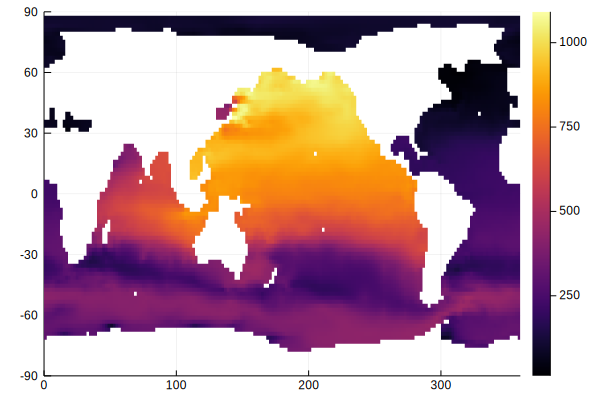

In [37]:
heatmap(lon, lat, age_3D[:,:,iz] * ustrip(1.0u"s" |> u"yr"))

That's it!
Good job!

At 1000m, the age ranges from a few years below deep water formation regions (Wedell Sea, North Atlantic), and reaches a dozen of centuries in the North Pacific! 
This is pretty good for so little work!

I hope this went well!
Thank you for being my guinea pigs, and let me know if you have any feedback!